In [1]:
import pandas as pd
import numpy as np
import statsmodels.formula.api as smf
import seaborn as sns
from toolz import *
from matplotlib import pyplot as plt
from matplotlib import style
style.use("ggplot")

# 24 - The Difference-in-Differences Saga
 
다시 `ATT`(`Average Treatment Effect`, 평균 처치 효과)로 돌아가 보겠습니다. 24장에서는 최근까지 연구된 패널 데이터 분석 방법을 공부해 보겠습니다. 패널 데이터는 시간에 걸쳐 반복적인 관측치를 갖는 (시계열) 구조를 가집니다. 긴 시간 동안 같은 `unit`에 대한 결과를 관찰함으로써 처치 전후에 어떤 일이 생기는지 쉽게 확인할 수 있습니다. 무작위 데이터를 얻을 수 없을 때 패널 데이터는 인과 관계를 확인할 수 있는 (거의) 유일한 방법입니다.
 
광고 분야는 무작위 실험이 무척 어렵습니다. 광고에 영향을 받는 사람을 통제할 수 없기 때문입니다. 새로운 사용자가 사이트에 접속하거나 앱을 다운로드하는 원인이 며칠 전 낸 광고인지, 아니면 알 수 없는 다른 요인에 의한 것인지 확인하기 어렵습니다. (이 문제를 해결하기 위한 많은 도구가 있지만 한계가 있습니다.) 

특히 오프라인 광고의 효과는 분석이 더 어렵습니다. TV 광고로 벌어들이는 수익이 광고비를 초과하는지 어떻게 알 수 있을까요? 일반적으로 사용하는 방법은 지역을 비교하는 것입니다. 광고를 낸 일부 지역과 그렇지 않은 지역을 비교합니다. 이를 위해는 여러 기간에 걸쳐 전체 지역의 데이터를 수집해야 합니다. 이러한 패널 데이터로 인과 효과를 구하는 가장 인기 있는 방법은 `DiD`(`Diff-in-Diff`) 계열입니다.

지난 2020~2021년에 걸쳐 `DiD`에 결함이 발견되었습니다. 이미 1부에서 `DiD`를 다루기는 했지만, 간단한 소개에 그쳤습니다. 여기서는 패널 데이터를 분석하는 새로운 방법에 대해 논의해 보도록 하겠습니다. 크게 세 개의 섹션으로 나눠 `Diff-in-Diff`의 활용 방법, 한계, 해결 방법을 설명하도록 하겠습니다.
 
1. **탄생**: 패널 데이터가 인과 추론에 매력적인 이유를 알아봅니다. `DiD` 및 `TWFE`(`Two Way Fixed Effect`, 양방향 고정 효과)가 어떻게 패널 데이터 구조를 활용하는지 복습합니다.
2. **죽음**: 1부에서 간과한 `DiD`, `TWFE` 모델의 핵심 가정을 살펴봅니다. 핵심 가정이 틀어질 때 발생하는 문제와 원인을 알아봅니다.  
3. **깨달음**: 문제에 대한 간단한 해결 방법을 소개합니다.
 
## 1) Birth: The Promise of Panel Data
 
![img](data/img/did-saga/promise.png)
 
패널 데이터는 시간 `t`에 걸쳐 상태 `i`를 측정한 데이터입니다. 대마초 합법화가 범죄율에 미치는 영향을 확인하려는 경우 `t`는 시간, `i`는 범죄율이 됩니다. 대마초 합법화는 `treatment`가 되며 `D`로 표기합니다. (시간 `t`와 구분하기 위해 `D`로 표기합니다.) `D`가 적용된 특정 주의 범죄율 추세를 확인할 수 있습니다. 상태 `i`는 그 자체로 대조군 역할을 할 수 있어 처치된 상태 (실험군)과 비교할 수 있습니다. `D` 전후 상태를 비교하면 인과 효과를 얻을 수 있습니다.
 
패널 데이터 분석은 산업 분야에서도 엄청나게 유용합니다. 일반적으로 회사는 긴 기간에 걸쳐 사용자 데이터를 추적해 풍부한 패널 데이터를 보유하고 있습니다. 무작위 실험을 할 수 없는 경우가 대부분이므로 패널 데이터에 의존해야 합니다. 앱을 설치한 사람을 분석하는 경우를 생각해봅시다. 회사는 2021년 여름에 앱에 새로운 기능을 출시했습니다. 당신은 새롭게 추가한 기능이 앱 설치에 얼마나 큰 영향을 주는지 알고 싶습니다. 새 기능 업데이트는 3회에 걸쳐 점진적으로 진행되었습니다. 일부 도시에서는 `2021-06-01`에 기능이 업데이트되었습니다. 다른 일부 도시는 `2021-07-15`, 나머지 도시에서는 `2022`년에 새 기능을 업데이트합니다. 데이터는 `2021-07-31`까지므로, 마지막 그룹은 대조군으로 사용합니다. `treatment`는 업데이트, `outcome`은 앱 설치 횟수가 됩니다. `outcome`에 대한 `treatment`의 효과, 즉 앱 설치에 대한 새로운 기능의 효과를 알고자 합니다.
 
어떤 사람이 새로운 기능을 가진 앱을 설치하는지 통제하기는 어렵습니다. 따라서 새로운 기능에 대한 무작위 실험은 불가능합니다. 분석하는 대상은 **아직 고객이 아닌 사람**으로 처치 할당에 대한 제한적인 통제권에 해당합니다. 무작위 실험을 하는 대신 도시 단위로 분석할 수 있습니다. 개인에 대해서는 비교할 방법이 없지만, 도시 별로는 가능합니다.

특정 시점에서 처치 받은 도시 그룹은 `cohort`라 하겠습니다. 총 세 개의 `cohort`가 존재합니다. 각각 `2021-06-01`에 처치 받은 그룹, `2021-07-15`에 처치 받은 그룹, 대조군 그룹입니다. 데이터 특징을 확인하기 위해 `cohort`에 따라 그룹화된 일일 평균 설치 횟수를 그려봅시다.

In [2]:
date = pd.date_range("2021-05-01", "2021-07-31", freq="D")
cohorts = pd.to_datetime(["2021-06-01", "2021-07-15", "2022-01-01"]).date
units = range(1, 100+1)

np.random.seed(1)

df = pd.DataFrame(dict(
    date = np.tile(date, len(units)),
    unit = np.repeat(units, len(date)),
    cohort = np.repeat(np.random.choice(cohorts, len(units)), len(date)),
    unit_fe = np.repeat(np.random.normal(0, 5, size=len(units)), len(date)),
    time_fe = np.tile(np.random.normal(size=len(date)), len(units)),
    week_day = np.tile(date.weekday, len(units)),
    w_seas = np.tile(abs(5-date.weekday) % 7, len(units)),
)).assign(
    trend = lambda d: (d["date"] - d["date"].min()).dt.days/70,
    day = lambda d: (d["date"] - d["date"].min()).dt.days,
    treat = lambda d: (d["date"] >= d["cohort"]).astype(int),
).assign(
    y0 = lambda d: 10 + d["trend"] + d["unit_fe"] + 0.1*d["time_fe"] + d["w_seas"]/10,
).assign(
    y1 = lambda d: d["y0"] + 1
).assign(
    tau = lambda d: d["y1"] - d["y0"],
    installs = lambda d: np.where(d["treat"] == 1, d["y1"], d["y0"])
)

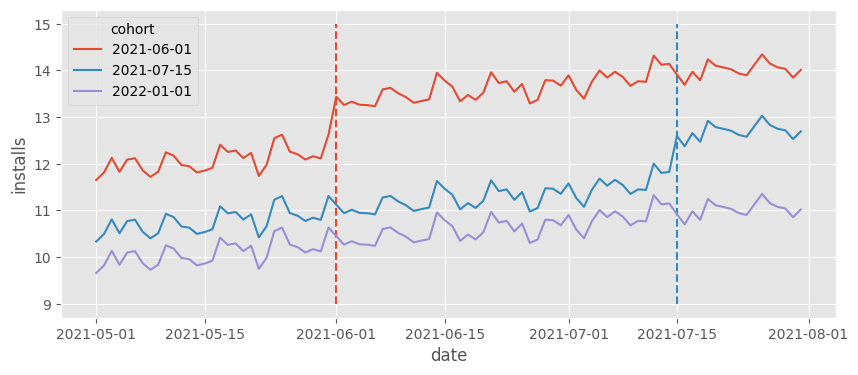

In [3]:
plt.figure(figsize=(10,4))
[plt.vlines(x=cohort, ymin=9, ymax=15, color=color, ls="dashed") for color, cohort in zip(["C0", "C1"], cohorts[:-1])]
sns.lineplot(
    data=(df
          .groupby(["cohort", "date"])["installs"]
          .mean()
          .reset_index()),
    x="date",
    y = "installs",
    hue="cohort",
);

점선은 `cohort`가 신규 기능을 업데이트한 순간을 나타냅니다. 각 `cohort`는 자체적인 수준을 가집니다. 도시마다 인구수에 따라 설치 횟수의 수준이 다르기 때문입니다. 첫 번째 `cohort`(`2021-06-01`)는 기준이 높으며, 대조군 `cohort`의 기준은 가장 낮습니다. 대조군의 $Y_{0}$가 실험군의 $Y_{0}$보다 낮아 $Y_{0}|G=Control < Y_{0}|G=Treated$가 되므로, 단순 비교는 편향된 효과를 주게 됩니다. 다행히도 해결이 어려운 문제는 아닙니다. 패널 데이터 구조상 모든 시간에 대한 데이터를 가지고 있으므로 개별 `cohort` 기준으로 값을 조정할 수 있습니다.
 
시간에 따라 (계절성으로 보이는) 꿈틀거림과 전반적인 상승 추세가 보입니다. 대조군은 5월에 약 10회에서 6월에 약 11회로 증가합니다. 전체적으로 시간이 지날수록 $Y_{0}$가 커집니다. 따라서 같은 도시에서도 시간이 다른 데이터를 단순히 비교하면 편향된 결과를 주게 됩니다. 패널 데이터 구조로 추세를 조정할 수 있다는 점은 다행입니다.

새로운 기능 업데이트가 설치 횟수에 미치는 영향을 추정하기 위해 신규 기능이 업데이트된 `cohort`에서 업데이트가 되지 않았다면 어땠을지 알아봅시다. 즉, 처치된 `cohort`의 `counterfactual`(반사실) $Y(0)$를 추정하고자 합니다. `cohort`가 처치 받은 시간 `t`를 `g`라 한다면 반사실은 $E[Y_0|t\geq g]$로 쓸 수 있습니다. `ATT`는 아래와 같습니다.

$$
E[Y_1|t \geq g] - E[Y_0|t\geq g]
$$
 
이제 우리가 가진 데이터로 `ATT`를 추정해봅시다. 한 가지 방법은 패널 데이터로 반사실을 추정하는 것입니다. 예를 들면 선형 회귀 분석이나 `Diff-in-Diff`로 `TWFE`(`Two Way Fixed Effect`) 모델을 얻을 수 있습니다. 각 도시에서 `i`의 기본 수준을 $\gamma_i$라 해봅시다. $\gamma_i$는 도시 규모를 의미합니다. 도시 규모에 따라 인구수가 달라지며 이는 기본 설치 수준을 결정합니다. 이유는 알 수 없지만 기본 수준은 **시간 불변의 매개 변수** $\gamma_i$로 표현됩니다. 마찬가지로 각 기간 `t`에 대해 **단위 불변의 매개 변수** $\theta_t$로 표현되는 기본 설치 수준이 존재합니다. 모델은 도시 효과 $\gamma_i$, 시간 효과 $\theta_t$, 일부 무작위 잡음 $e_{it}$의 총합입니다.

$$
Installs_{it} = \gamma_i + \theta_t + e_{it}
$$
 
위 방정식에 처치 `D`를 포함하기 위해 처치가 할당되면 $1$이고 그렇지 않으면 $0$인 변수 $D_{it}$를 추가합니다. 데이터에서 대조군은 항상 $0$입니다. 초기에는 모든 `cohort`에서 값이 $0$이지만, `2021-06-01`에서 일부 도시(`cohort`)에서 $1$로 바뀌고 이후에 $1$로 유지됩니다. `2021-07-15`에 처치된 `cohort`의 경우 `2021-07-15`에서 $1$로 바뀝니다. 방정식은 아래와 같습니다.

$$
Installs_{it} = \tau D_{it} + \gamma_i + \theta_t + e_{it}
$$
 
`OLS`로 위 모델을 추정하는 것을 `TWFE`라 합니다. 여기서 인과 효과는 $\tau$와 같습니다.

$\tau$를 얻는 간단한 방법은 `i`와 `t`를 고정한 상태에서 `D`만 $0$에서 $1$로 뒤집는 것입니다. 이를 통해 설치 횟수가 얼마나 바뀌는지에 대한 추정치 $\tau$를 얻을 수 있습니다.

이는 대담한 접근입니다! $D$의 효과를 측정하는 동안 다른 모든 것을 고정하는 것은 알려진 것과 알려지지 않은 모든 특성을 통제하는 것과 같습니다. `i`를 고정하는 것은 도시 별 기본 설치 수준 외에도 도시 문화 등 전혀 알지 못하는 것도 통제하는 것과 같습니다. `t`를 고정하는 것은 모든 시간 특성(계절성, 상승 추세)을 통제하는 것과 같습니다.

`tau`를 구하기 위해 `OLS`를 실행해 봅시다. 데이터는 신기능 업데이트 효과 설치 횟수가 $1$회 증가하는 방식으로 만들어졌습니다. 이론적인 `tau`는 $1$이며, `TWFE`는 처치 효과를 완벽하게 추정합니다.

In [4]:
formula = f"""installs ~ treat + C(unit) + C(date)"""
twfe_model = smf.ols(formula, data=df).fit()
twfe_model.params["treat"]

1.0000000000000544

데이터는 시뮬레이션 된 것이므로 우리는 이미 `ITE`(`individual treatment effect`)를 알고 있습니다. `TWFE`의 추정값과 실제 `ATT`가 일치하는지 확인해봅시다. `treat`가 $1$인 데이터만 필터링해 `tau`의 평균값을 계산합니다.

In [5]:
df.query("treat==1")["tau"].mean()

1.0

`unit`별로 $\tau \tilde D_{it}$에 해당하는 `dummy`를 만드는 것은 원리적으로 불가능하지만 다룰수 있습니다. `FWL`(`Frisch–Waugh–Lovell`) 정리로 단일 회귀 모델을 두 개로 분리할 수 있습니다. 위의 모델은 아래와 같습니다.

$$
\tilde{Installs}_{it} = \tau \tilde D_{it} + e_{it}
$$
 
where 
 
$$
\tilde{Installs}_{it} = Installs_{it} - \underbrace{\frac{1}{T}\sum_{t=0}^T Installs_{it}}_\text{Time Average} - \underbrace{\frac{1}{N}\sum_{i=0}^N Installs_{it}}_\text{Unit Average}
$$
 
and
 
$$
\tilde{D}_{it} = D_{it} - \frac{1}{T}\sum_{t=0}^T D_{it} - \frac{1}{N}\sum_{i=0}^N D_{it}
$$
 
즉, `outcome`에서 시간에 따른 `unit` 평균(첫 번째 항)과 `unit`에 따른 시간 평균(두 번째 항)을 빼서 잔차를 계산합니다. `outcome`과 `treatment`에서 평균을 빼는 과정이 있어 `de-meaning`이라고도 불립니다. 코드는 다음과 같습니다.

In [6]:
@curry
def demean(df, col_to_demean):
    return df.assign(**{col_to_demean: (df[col_to_demean]
                                        - df.groupby("unit")[col_to_demean].transform("mean")
                                        - df.groupby("date")[col_to_demean].transform("mean"))})

formula = f"""installs ~ treat"""
mod = smf.ols(formula,
              data=df
              .pipe(demean(col_to_demean="treat"))
              .pipe(demean(col_to_demean="installs")))

result = mod.fit()
result.summary().tables[1]

,coef,std err,t,P>|t|,[0.025,0.975]
Intercept,-11.4580,1.36e-15,-8.44e+15,0.000,-11.458,-11.458
treat,1.0000,3.43e-15,2.92e+14,0.000,1.000,1.000


`TWFE` 모델이 무엇을 하고 있는지 이해하기 위해 반사실적 예측값 $\hat{Y_0}|t \geq g$를 그려봅시다. 처치 효과 $\hat{\tau}$는 반사실적 예측값과의 차이인 $Y_1 - \hat{Y_0}$와 같습니다. 아래 그림에서 $\hat{Y_0}$은 점선으로 그렸습니다.

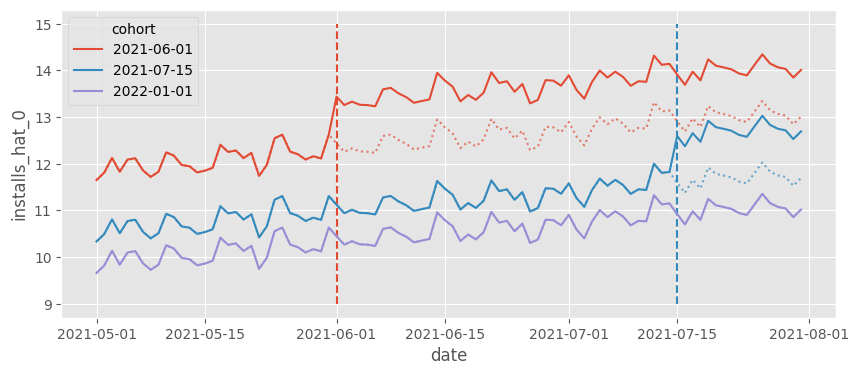

In [7]:
df_pred = df.assign(**{"installs_hat_0": twfe_model.predict(df.assign(**{"treat":0}))})          

plt.figure(figsize=(10,4))
[plt.vlines(x=cohort, ymin=9, ymax=15, color=color, ls="dashed") for color, cohort in zip(["C0", "C1"], cohorts[:-1])]
sns.lineplot(
    data=(df_pred
          .groupby(["cohort", "date"])["installs_hat_0"]
          .mean()
          .reset_index()),
    x="date",
    y = "installs_hat_0",
    hue="cohort",
    alpha=0.7,
    ls="dotted",
    legend=None
)
sns.lineplot(
    data=(df_pred
          .groupby(["cohort", "date"])["installs"]
          .mean()
          .reset_index()),
    x="date",
    y = "installs",
    hue="cohort",
);

위 그래프는 `TWFE`가 통제된 데이터의 추세를 처치된 `unit`에 투영하는 방법, 수준을 보정하는 방법을 보여줍니다. 빨간색 `cohort`의 `counterfactual` $Y_0$는 다른 `cohort`의 평균적인 추세를 따르며 수준이 보정되었습니다. 따라서 `TWFE`는 `Difference-in-Differences`의 일종입니다. 다양한 기간, 다양한 `unit`에 대해서도 잘 작동합니다. ($2$ `unit`, $2$ 기간의 경우 `TWFE`와 `DiD`는 결과가 같습니다.)

## 2) Death: Failures over Effect Heterogeneity
 
`DiD`와 `TWFE`는 시간, `unit` 변동을 고려해 반사실을 잘 추정할 수 있다는 장점이 있습니다. 강력한 인과 추론이 가능하지만, 항상 사용할 수 있는 것은 아닙니다. 최근 연구에 따르면 `TWFE`를 확장하는 것은 생각만큼 간단하지 않습니다. **TWFE에서 편향되는 사례가 발견되기도 했습니다.** 이를 계기로 `TWFE`를 사용한 경제학 분야의 연구 논문이 잇달아 수정되기도 했습니다. 무엇이 문제일까요? 기본 가정부터 시작해 봅시다.

![img](data/img/did-saga/death.png)
 
단순한 시간 효과가 없는 `FE`(`Fixed Effect`) 모델을 고려해봅시다.

$$
y_{it} = \tau D_{it} + \gamma_i + e_{it}
$$
 
모델의 가정은 크게 둘로 나뉩니다.

1. Functional Form Assumptions
    * 시간에 따라 일정한 효과를 보이며 이질적인 효과가 없습니다.
    * 공변량은 선형성을 가집니다.
    * 추가적인 고정 효과를 가질 수 있습니다.
2. Strict Exogeneity
    * 평행 추세
    * 예측 없음
    * 측정하지 않은, 시간에 따라 달라지는 교란 변수가 없습니다
    * 과거의 처치는 현재 결과에 영향을 주지 않습니다.
    * 과거의 결과는 현재 처치에 영향을 주지 않습니다.
    
여기서는 `Functional Form Assumptions`을 유지하겠습니다. 공변량의 선형성은 잘 알려져 있으며, 모든 선형 회귀 모델에 적용할 수 있습니다. 또한, 기계학습 모델을 사용해 쉽게 가정을 완화할 수 있기도 합니다. 원한다면 언제나 공변량의 선형성을 일정 수준으로 완화할 수 있습니다. 선형성 가정은 큰 제한이 아니므로 문제를 만드는 경우가 적습니다. 이제 (많은 논란을 불러온) 시간에 따른 이질성을 알아봅시다.

### Treatment Effect Heterogeneity in Time
 
앱 사용자가 업데이트된 새로운 기능에 익숙해지려면 시간이 걸리기 마련입니다. 광고한다고 설치가 즉각적으로 늘어나지는 않습니다. 보통 효과는 시간에 따라 점진적으로 나타나며 심지어 광고가 끝난 후에 새로운 사용자가 생기기도 합니다. 이러한 특징은 가정과 다릅니다. 앞에서는 `treatment`가 적용되는 순간 앱 설치가 즉각적으로 늘어난다고 가정했습니다. 데이터를 현실적으로 바꿔봅시다. 여전히 `ATT`는 $1$이지만 열흘에 걸쳐 커집니다. $1$일 차에 $0.1$, $2$일 차에 $0.2$, $10$일 차에 $1.0$입니다. 추세가 눈에 띄도록 `t`의 스케일을 줄여보겠습니다.

In [8]:
date = pd.date_range("2021-05-01", "2021-07-31", freq="D")
cohorts = pd.to_datetime(["2021-06-01", "2021-07-15", "2022-01-01"]).date
units = range(1, 100+1)

np.random.seed(1)

df_heter = pd.DataFrame(dict(
    date = np.tile(date.date, len(units)),
    unit = np.repeat(units, len(date)),
    cohort = np.repeat(np.random.choice(cohorts, len(units)), len(date)),
    unit_fe = np.repeat(np.random.normal(0, 5, size=len(units)), len(date)),
    time_fe = np.tile(np.random.normal(size=len(date)), len(units)),
    week_day = np.tile(date.weekday, len(units)),
    w_seas = np.tile(abs(5-date.weekday) % 7, len(units)),
)).assign(
    trend = lambda d: (d["date"] - d["date"].min()).dt.days/70,
    day = lambda d: (d["date"] - d["date"].min()).dt.days,
    treat = lambda d: (d["date"] >= d["cohort"]).astype(int),
).assign(
    y0 = lambda d: 10 + d["trend"] + 0.2*d["unit_fe"] + 0.05*d["time_fe"] + d["w_seas"]/50,
).assign(
    y1 = lambda d: d["y0"] + np.minimum(0.1*(np.maximum(0, (d["date"] - d["cohort"]).dt.days)), 1)
).assign(
    tau = lambda d: d["y1"] - d["y0"],
    installs = lambda d: np.where(d["treat"] == 1, d["y1"], d["y0"])
)

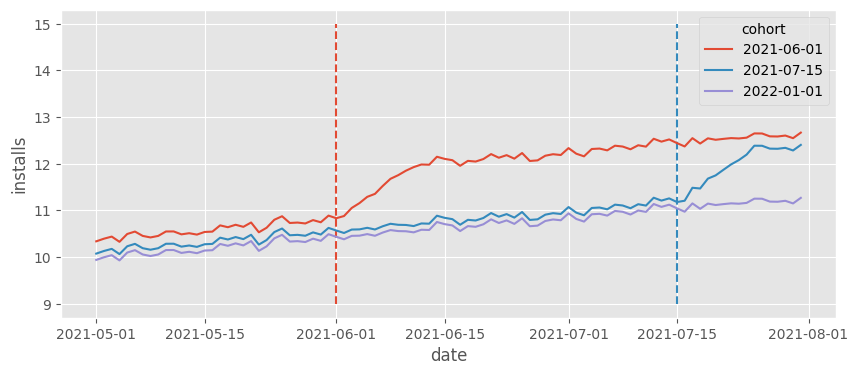

In [9]:
plt.figure(figsize=(10,4))
[plt.vlines(x=cohort, ymin=9, ymax=15, color=color, ls="dashed") for color, cohort in zip(["C0", "C1"], cohorts)]
sns.lineplot(
    data=(df_heter
          .groupby(["cohort", "date"])["installs"]
          .mean()
          .reset_index()),
    x="date",
    y = "installs",
    hue="cohort",
);

이제 광고는 앱 설치에 열흘에 걸쳐 영향을 줍니다. 더 그럴듯하죠? 실제로 우리가 보는 대부분 데이터는 이렇게 생겼습니다. 좋습니다. 그럼 `TWFE` 모델의 결과를 확인해 봅시다.

In [10]:
formula = f"""installs ~ treat + C(date) + C(unit)"""

twfe_model = smf.ols(formula, data=df_heter).fit()

print("Estimated Effect: ", twfe_model.params["treat"])
print("True Effect: ", df_heter.query("treat==1")["tau"].mean())

Estimated Effect:  0.7867708225724896
True Effect:  0.8544117647058823


`ATT`는 $1$이 아닙니다. 광고 초기에 효과가 $1$보다 작기 때문입니다. 더 중요한 사실은 **TWFE로 추정한 ATE가 실제 ATE와 다르다는 것입니다.** `TWFE`는 편향되어 있습니다. 데이터는 평행한 추세를 따르는 등 모든 `strict exogeneity` 가정을 만족합니다. 그렇다면 편향의 원인은 무엇일까요? 
 
편향을 이해하는 첫 번째 단계는 `TWFE`를 $2$ X $2$ `Diff-in-Diffs`로 분해하는 것입니다.

아래와 같이 $4$ 종류 비교를 수행합니다.
1. 일찍 처치된 것(`early treated`)과 처치되지 않은 것(`never treated`)
2. 나중에 처치된 것(`late treated`)과 `never treated`
3. 실험군 `early treated`와 대조군 `late treated`
4. 실험군 `late treated`와 대조군 `early treated`

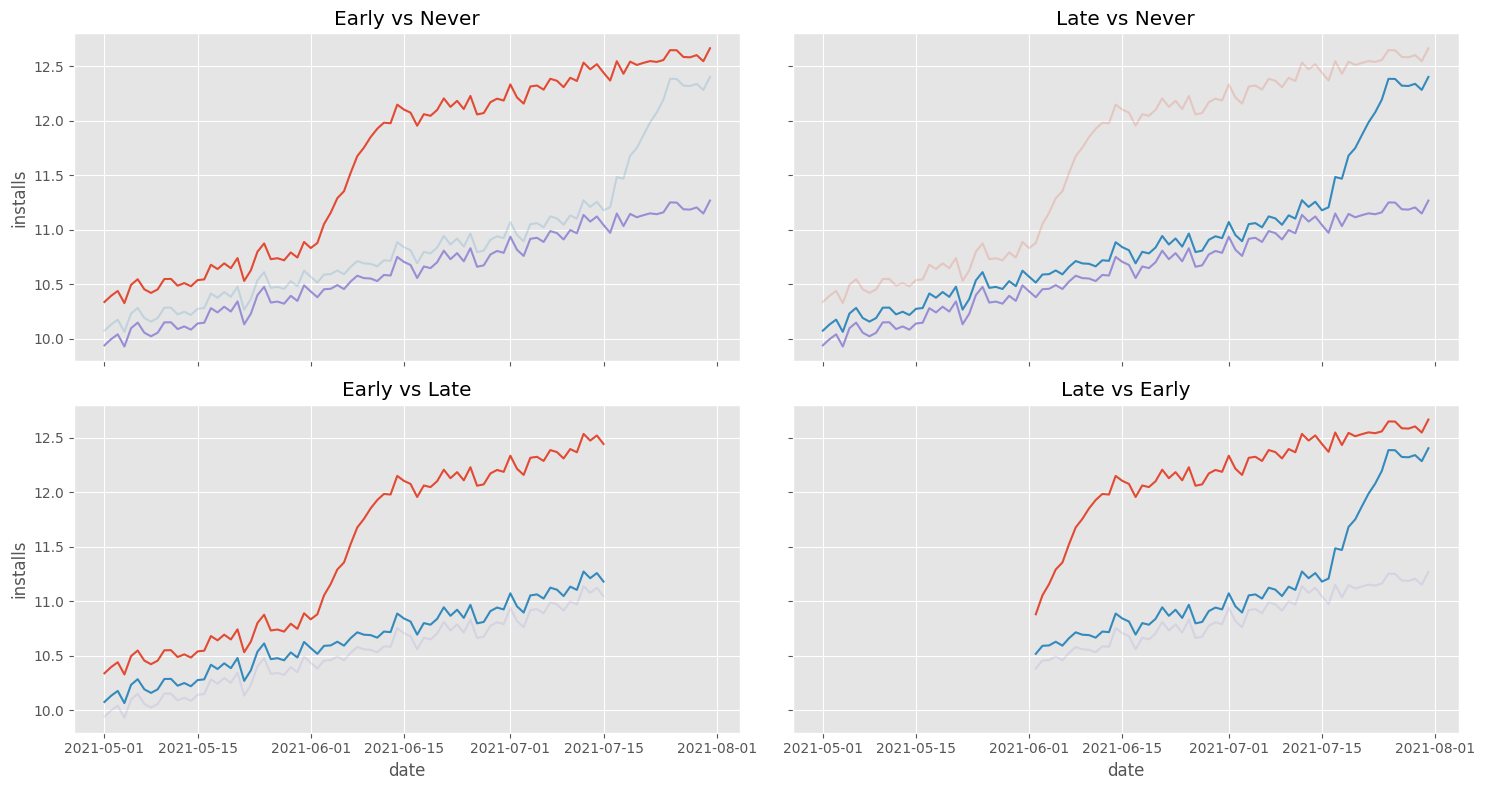

In [11]:
g_plot_data = (df_heter
               .groupby(["cohort", "date"])["installs"]
               .mean()
               .reset_index()
               .astype({"cohort":str}))


fig, axs = plt.subplots(2, 2, figsize=(15,8), sharex=True, sharey=True)

def plot_comp(df, ax, exclude_cohort, name):
    
    palette=dict(zip(map(str, cohorts), ["C0", "C1", "C2"]))
    
    sns.lineplot(
        data=df.query(f"cohort != '{exclude_cohort}'"),
        x="date",
        y="installs",
        hue="cohort",
        palette=palette,
        legend=None,
        ax=ax
    )

    sns.lineplot(
        data=df.query(f"cohort == '{exclude_cohort}'"),
        x="date",
        y = "installs",
        hue="cohort",
        palette=palette,
        alpha=0.2,
        legend=None,
        ax=ax
    )
    
    ax.set_title(name)

plot_comp(g_plot_data, axs[0,0], cohorts[1], "Early vs Never")
plot_comp(g_plot_data, axs[0,1], cohorts[0], "Late vs Never")

plot_comp(g_plot_data[g_plot_data["date"]<=cohorts[1]], axs[1,0], cohorts[-1], "Early vs Late")
plot_comp(g_plot_data[g_plot_data["date"]>cohorts[0]], axs[1,1], cohorts[-1], "Late vs Early")

plt.tight_layout();

처음 세 가지 비교는 대조군이 잘 작동하므로 걱정하지 않아도 됩니다. 네 번째 비교는 `treated` 데이터를 대조군으로 사용하여 문제가 있습니다. `early treated`는 처음에 급격히 증가하는데, 이는 `ATT`의 점진적인 증가를 반영합니다. 따라서 `DiD`의 반사실 추정이 엉망이 됩니다. 그래프로 네 번째 비교에서 `late treated`의 `counterfactual` $Y_0$를 그려보겠습니다.

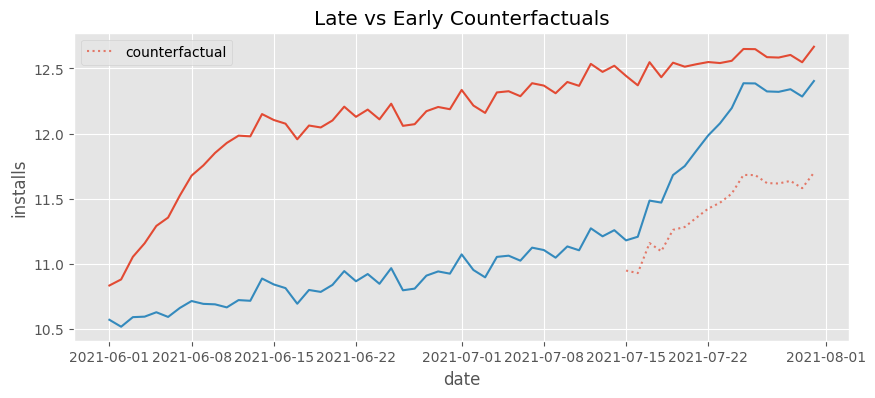

In [12]:
late_vs_early = (df_heter
                 [df_heter["date"].astype(str)>="2021-06-01"]
                 [lambda d: d["cohort"].astype(str)<="2021-08-01"])


formula = f"""installs ~ treat + C(date) + C(unit)"""

twfe_model = smf.ols(formula, data=late_vs_early).fit()

late_vs_early_pred = (late_vs_early
                      .assign(**{"installs_hat_0": twfe_model.predict(late_vs_early.assign(**{"treat":0}))})
                      .groupby(["cohort", "date"])
                      [["installs", "installs_hat_0"]]
                      .mean()
                      .reset_index())


plt.figure(figsize=(10,4))
plt.title("Late vs Early Counterfactuals")
sns.lineplot(
    data=late_vs_early_pred,
    x="date",
    y = "installs",
    hue="cohort",
    legend=None
)

sns.lineplot(
    data=(late_vs_early_pred
          [late_vs_early_pred["cohort"].astype(str) == "2021-07-15"]
          [lambda d: d["date"].astype(str) >= "2021-07-15"]
         ),
    x="date",
    y ="installs_hat_0",
    alpha=0.7,
    color="C0",
    ls="dotted",
    label="counterfactual"
);

`counterfactual`은 필요보다 가파른 추세를 가지며 이는 `treated` 데이터의 초기 증가분을 반영하기 때문입니다.
 
기술적으로 `strict exogeneity`(병렬 추세, 예측 없음 등)를 만족할 때 `cohort`의 크기가 같다면 `TWFE`는 모델은 다음을 만족함을 보일 수 있습니다. (Goodman-Bacon, 2019)

$$
plim_{x \to \infty} \hat{\tau}^{TWFE} = VWATT - \Delta ATT
$$
 
첫 번째 항은 여러 `DiD` 비교로 얻은 `variance weighted ATT`로 우리가 얻고자 하는 인과 효과입니다. 두 번째 항은 추가적인 $\Delta ATT$입니다. $\Delta ATT$는 시간에 따른 `ATT`의 변화량을 나타내며 편향의 원인입니다. 시간에 따라 효과가 증가하면 하향 편향, 효과가 감소하면 상향 편향이 생깁니다.

데이터에서는 `TWFE`의 효과가 실제 `ATT`보다 작습니다. 결과는 더 극단적일 수 있습니다. 편향이 `ATT`를 반대로 만들 정도로 강한 경우를 살펴보겠습니다. 단 두 개 `cohort`로 이루어진 간단한 경우를 생각해 봅시다. 처치 효과는 음수로 매일 $0.1$씩 감소합니다. 시간에 따른 고정 효과와 추세는 없다고 가정합니다.

In [13]:
date = pd.date_range("2021-05-15", "2021-07-01", freq="D")
cohorts = pd.to_datetime(["2021-06-01", "2021-06-15"])
units = range(1, 100+1)

np.random.seed(1)

df_min = pd.DataFrame(dict(
    date = np.tile(date, len(units)),
    unit = np.repeat(units, len(date)),
    cohort = np.repeat(np.random.choice(cohorts, len(units)), len(date)),
    unit_fe = np.repeat(np.random.normal(0, 5, size=len(units)), len(date)),
)).assign(
    trend = 0,
    day = lambda d: (d["date"] - d["date"].min()).dt.days,
    treat = lambda d: (d["date"] >= d["cohort"]).astype(int),
).assign(
    y0 = lambda d: 10 - d["trend"] + 0.1*d["unit_fe"]
).assign(
    y1 = lambda d: d["y0"] - 0.1*(np.maximum(0, (d["date"] - d["cohort"]).dt.days))
).assign(
    tau = lambda d: d["y1"] - d["y0"],
    installs = lambda d: np.where(d["treat"] == 1, d["y1"], d["y0"])
)

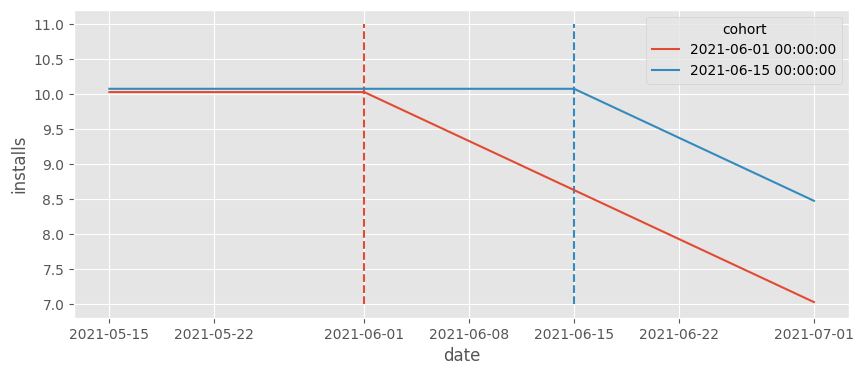

In [14]:
plt.figure(figsize=(10,4))
[plt.vlines(x=cohort, ymin=7, ymax=11, color=color, ls="dashed") for color, cohort in zip(["C0", "C1"], cohorts)]
sns.lineplot(
    data=(df_min
          .groupby(["cohort", "date"])["installs"]
          .mean()
          .reset_index()),
    x="date",
    y = "installs",
    hue="cohort",
);

그림에 따르면 `ATT`는 음수입니다. `counterfactual`은 $10$에서 직선이어야 합니다. 하지만 `TWFE`는 양의 `ATT`를 줍니다.

In [15]:
formula = f"""installs ~ treat + C(date) + C(unit)"""
twfe_model = smf.ols(formula, data=df_min).fit()
twfe_model.params["treat"]

0.04999999999999709

다시 한번 `early treated`가 `late treated`의 대조군 역할을 하는 경우를 살펴봅시다. `DiD`와 마찬가지로 `TWFE`는 대조군에서 처치 그룹의 수준으로 추세를 조정하므로 반사실은 이를 반영해야 합니다.

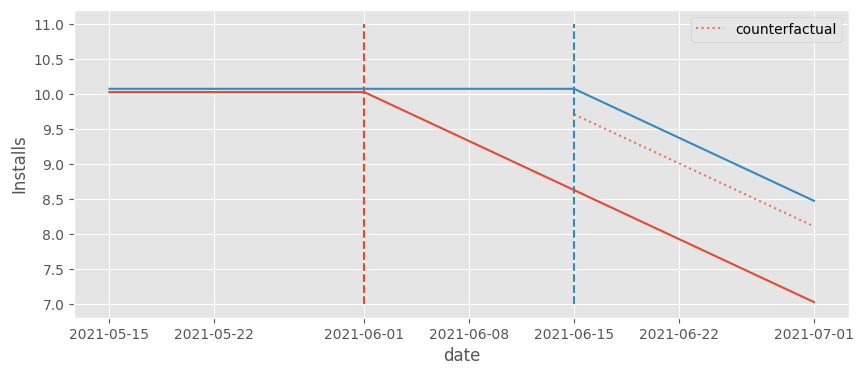

In [16]:
df_pred = df_min.assign(**{"installs_hat_0": twfe_model.predict(df_min.assign(**{"treat":0}))})
          
plt.figure(figsize=(10,4))
[plt.vlines(x=cohort, ymin=7, ymax=11, color=color, ls="dashed") for color, cohort in zip(["C0", "C1"], cohorts)]
sns.lineplot(
    data=(df_pred
          [(df_pred["cohort"].astype(str) > "2021-06-01") & (df_pred["date"].astype(str) >= "2021-06-15")]
          .groupby(["cohort", "date"])["installs_hat_0"]
          .mean()
          .reset_index()),
    x="date",
    y = "installs_hat_0",
    alpha=0.7,
    ls="dotted",
    color="C0",
    label="counterfactual",
)
sns.lineplot(
    data=(df_pred
          .groupby(["cohort", "date"])["installs"]
          .mean()
          .reset_index()),
    x="date",
    y = "installs",
    hue="cohort",
    legend=None
)
plt.ylabel("Installs");

반사실의 수준은 원래보다 아래에 위치합니다. `early treated`는 수준을 $10$에서 약 $9.7$ 정도로 낮춥니다. 또한 반사실이 하락 추세를 보이는데, 이는 옳지 않습니다. 반사실이 $10$에서 직선이어야 한다는 것은 꽤 분명하지만 `early treated`를 대조군으로 사용할 경우 일정하게 감소하는 추세를 보입니다.

최종 결과는 반사실 $Y_0$가 $Y_1$ 결과보다 작으므로 양수입니다. 그림에 따르면 올바른 반사실은 값이 $10$인 직선임이 분명하지만, `TWFE`는 단순히 `early treated`를 대조군으로 사용하므로 제대로 된 `ATT`를 주지 못합니다.
 
#### Event Study Design
 
어떤 사람들은 `Event Study Design`으로 문제를 해결할 수 있다고 주장합니다. `Event Study Design`은 처치 전후 기간에 각각 하나의 더미변수를 추가합니다. 원래의 `TWFE` 모델은 아래와 같이 변경됩니다.

$$
Y_{i,t} = \tau^{-K}~ D_{i,t}^{<-K} + \sum_{k=-K}^{-2} \tau^{lead} D_{i,t}^{k} +\sum_{k=0}^{L} \gamma_k^{lag} D_{i,t}^{k} + \gamma_k^{L+} D_{i,t}^{>L} \gamma_i + e_{it}
$$
 
$D^k_{i,t}=1\{t-\text{Cohort}_i=k\}$는 `unit`이 `k`만큼 떨어져 있으면 $1$이고 그렇지 않으면 $0$인 `event study dummy`입니다. 수식은 복잡해 보이지만 코드는 단순합니다. 처치가 적용된 시점에서 떨어진 거리 `relative_days`를 추가하기만 하면 됩니다.

In [17]:
df_min_rel = (df_min
              .assign(relative_days = (df_min["date"] - df_min["cohort"]).dt.days))

df_min_rel.head()

,date,unit,cohort,unit_fe,trend,day,treat,y0,y1,tau,installs,relative_days
0,2021-05-15,1,2021-06-15,-3.435864,0,0,0,9.656414,9.656414,0.0,9.656414,-31
1,2021-05-16,1,2021-06-15,-3.435864,0,1,0,9.656414,9.656414,0.0,9.656414,-30
2,2021-05-17,1,2021-06-15,-3.435864,0,2,0,9.656414,9.656414,0.0,9.656414,-29
3,2021-05-18,1,2021-06-15,-3.435864,0,3,0,9.656414,9.656414,0.0,9.656414,-28
4,2021-05-19,1,2021-06-15,-3.435864,0,4,0,9.656414,9.656414,0.0,9.656414,-27


`relative_days`로 모델은 각 기간에 대한 예상 설치 수를 실험군과 비교해 추정할 수 있습니다. 그리고 나면 처치 전 마지막 날(`relative_days`$=-1$)과 비교해 예상되는 추가 설치 횟수로 인과 효과를 정의할 수 있습니다.
 
공식이 `ATT`의 시간 이질성을 고려해 문제를 해결해줄까요? 그렇지 않습니다. `counterfactual`을 그려보면 직관적인 결과 ($10$의 수평선)에서 떨어져 있다는 것을 확인할 수 있습니다.

In [18]:
# remove the intercept, otherwise effects will be relative to relative day -30
formula = f"installs ~ -1 + C(relative_days) + C(date) + C(unit)"
twfe_model = smf.ols(formula, data=df_min_rel).fit()

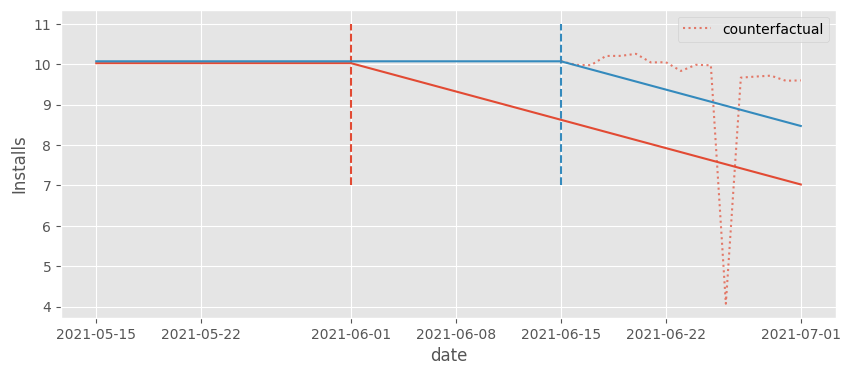

In [19]:
df_pred = df_min_rel.assign(
    installs_hat_0=twfe_model.predict(df_min_rel.assign(relative_days=-1))
) 

plt.figure(figsize=(10,4))
[plt.vlines(x=cohort, ymin=7, ymax=11, color=color, ls="dashed") for color, cohort in zip(["C0", "C1"], cohorts)]
sns.lineplot(
    data=(df_pred
          [(df_pred["cohort"].astype(str) > "2021-06-01") & (df_pred["date"].astype(str) >= "2021-06-15")]
          .groupby(["cohort", "date"])["installs_hat_0"]
          .mean()
          .reset_index()),
    x="date",
    y = "installs_hat_0",
    alpha=0.7,
    ls="dotted",
    color="C0",
    label="counterfactual",
)
sns.lineplot(
    data=(df_pred
          .groupby(["cohort", "date"])["installs"]
          .mean()
          .reset_index()),
    x="date",
    y = "installs",
    hue="cohort",
    legend=None
)
plt.ylabel("Installs");

![img](data/img/did-saga/awful.jpeg)

그래도 `counterfactual`이 $Y_1$보다는 높게 위치하므로 조금 더 좋아 보입니다. 이는 음의 `ATT`를 줄 수 있습니다. 확인을 위해 더미와 관련된 매개 변수와 $-1$(기준선)과 관련된 매개 변수의 차를 계산해 추정된 효과를 그려봅시다.

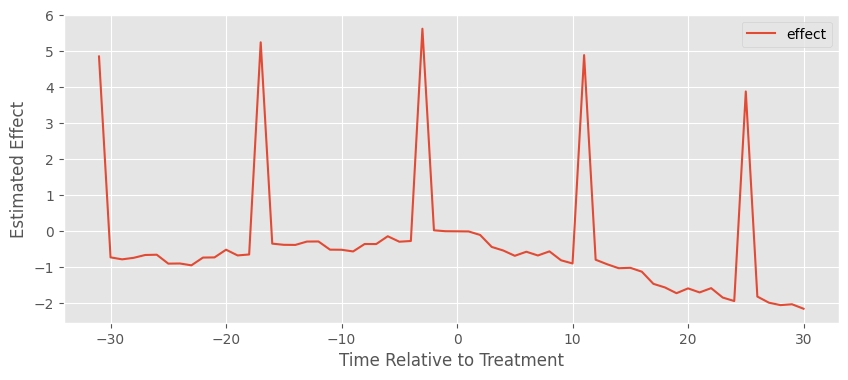

In [20]:
effects = (twfe_model.params[twfe_model.params.index.str.contains("relative_days")]
           .reset_index()
           .rename(columns={0:"effect"})
           .assign(relative_day=lambda d: d["index"].str.extract(r'\[(.*)\]').astype(int))
           # set the baseline to period -1
           .assign(effect = lambda d: d["effect"] - d.query("relative_day==-1")["effect"].iloc[0]))

# effects
effects.plot(x="relative_day", y="effect", figsize=(10,4))
plt.ylabel("Estimated Effect")
plt.xlabel("Time Relative to Treatment");

적어도 처치 후 1) 대부분 효과가 음수이며, 2) 감소 추세가 있으므로 보통의 `TWFE`보다는 더 좋습니다. 하지만 이상한 뾰족점과 양의 효과로 보이는 것들이 있으며 명백히 틀린 결과입니다.
 
앞에서 언급한 것과 같은 문제입니다. 조기에 처치된 데이터가 나중에 처치된 데이터의 대조군으로 사용되기 때문입니다. 상대적인 시간을 추가한다고 문제가 해결되지는 않아 보입니다.
 
## 3) Enlightenment: A Flexible Functional Form
 
좋은 소식과 나쁜 소식이 있습니다. 좋은 소식은 문제가 `functional form`과 관련 있으므로 함수 형태를 고쳐 해결할 수 있다는 것입니다. 다시 말하지만 `TWFE`의 편향은 시간 이질성 때문입니다. 효과가 나타나는 데 시간이 걸리는 경우 이러한 현상이 발생합니다. 앞에서 본 천천히 나타나는 광고효과가 이에 해당합니다. 고전적인 `TWFE`의 `functional form`은 시간 이질성을 다루기에 충분히 유연하지 않아 편향이 생깁니다. 문제를 알았으므로 해결에 한 걸음 더 가까워졌습니다.
 
`Event Study Design`에서 개별 시간 기간에 상대적인 효과를 허용하는 것으로는 충분하지 않았습니다. 큰 효과는 없었지만, 의도는 좋았습니다. `Event Study Design`은 모델을 유연하게 만드는 방법입니다. 모델을 훨씬 더 유연하게 만들 필요가 있습니다.

앱 설치 예시로 돌아가 봅시다. 이 데이터에 단순 `TWFE` 모델은 작동하지 않습니다.
 
$$
Installs_{it} = \tau D_{it} + \gamma_i + \theta_t + e_{it}
$$
 
원인은 모델이 너무 제한적인 데 있습니다. 모델은 $\tau_{it}=\tau \ \forall i, t$ 즉, 시간 동질성을 가정합니다. 간단한 해결 방법은 `i`, `t`에 대해 다른 효과를 허용하는 것입니다.
 
$$
Installs_{it} = \sum_{i=0}^N \sum_{t=0}^T \tau_{it} D_{it} + \gamma_i + \theta_t + e_{it}
$$
 
위 방정식은 아래 수식을 실행하는 것과 같습니다.

```
installs ~ treat:C(unit):C(date) + C(unit) + C(date)
```
 
안타깝지만 실행은 불가능합니다. 매개 변수의 개수가 데이터보다 많기 때문입니다. `i`, `t`와 상호작용하므로 $i \times t$에 대해 하나의 처치 효과 매개 변수가 존재합니다. 이는 데이터 개수과 같습니다. `OLS`는 작동하지 않을 겁니다.

모델의 처치 효과 매개 변수의 개수를 줄여봅시다. 어떻게든 `unit`을 그룹화해 봅니다. `cohort` 별로 그룹을 만드는 것이 자연스러워 보입니다. `cohort` 내에서는 `treatment effect`가 시간과 무관하게 같기 때문입니다. 아래와 같이 `unit` 대신 `cohort`의 따른 효과를 구하는 것으로 바꿀 수 있습니다.
 
$$
Installs_{it} = \sum_{g=0}^G \sum_{t=0}^T \tau_{gt} D_{it} + \gamma_i + \theta_t + e_{it}
$$
 
`G`는 `cohort`의 총개수, `g`는 개별 `cohort`를 나타냅니다. 일반적으로 `G`는 `N`보다 훨씬 작은 값이므로 더 적은 수의 처치 효과 매개 변수($T \times G$)를 가집니다. 이제 해볼 만합니다.

In [21]:
formula = f"""installs ~ treat:C(cohort):C(date) + C(unit) + C(date)"""

# for nicer plots latter on
df_heter_str = df_heter.astype({"cohort": str, "date":str})

twfe_model = smf.ols(formula, data=df_heter_str).fit()

이 방법이 효과 있는지 확인하기 위해 모든 데이터에 `treat`가 $0$이 되도록 하여 `conuterfactual` $Y_0$를 예측합니다. `ATT`는 $Y_1$에서 $\hat{Y}_0$를 빼면 구할 수 있습니다. `ATT` 예측값과 실제 `ATT`가 일치하는지 확인해 보겠습니다.

In [22]:
df_pred = (df_heter_str
           .assign(**{"installs_hat_0": twfe_model.predict(df_heter_str.assign(**{"treat":0}))})
           .assign(**{"effect_hat": lambda d: d["installs"] - d["installs_hat_0"]}))

print("Number of param.:", len(twfe_model.params))
print("True Effect: ", df_pred.query("treat==1")["tau"].mean())
print("Pred. Effect: ", df_pred.query("treat==1")["effect_hat"].mean())

Number of param.: 467
True Effect:  0.8544117647058823
Pred. Effect:  0.8544117647058833


좋습니다! 마침내 시간 이질성을 고려하는 유연한 모델을 만들었습니다. 이제 올바른 처치 효과를 추정할 수 있습니다. 추가로 시간과 `cohort` 별로 추정한 효과를 그려봅시다. 데이터가 어떻게 생성되었는지 알고 있으므로 정답과 비교할 수 있습니다. 효과는 처치 전에는 $0$이며, 처치하고 10일 후 $1$로 증가해야 합니다.

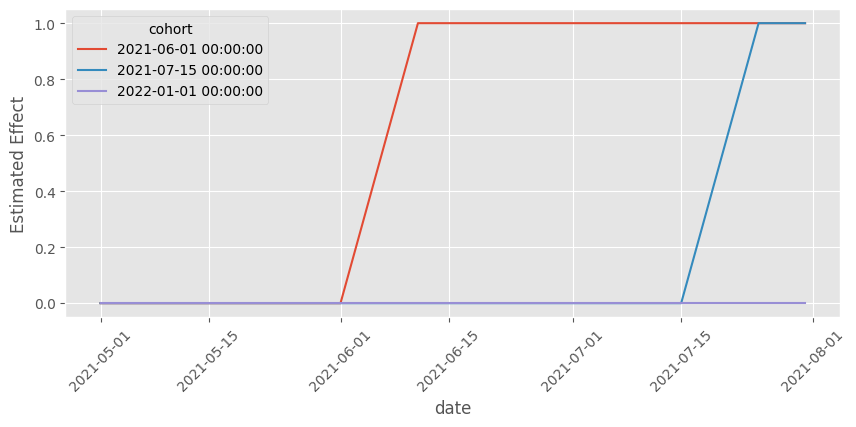

In [23]:
effects = (twfe_model.params[twfe_model.params.index.str.contains("treat")]
           .reset_index()
           .rename(columns={0:"param"})
           .assign(cohort=lambda d: d["index"].str.extract(r'C\(cohort\)\[(.*)\]:'))
           .assign(date=lambda d: d["index"].str.extract(r':C\(date\)\[(.*)\]'))
           .assign(date=lambda d: pd.to_datetime(d["date"]), cohort=lambda d: pd.to_datetime(d["cohort"])))

plt.figure(figsize=(10,4))
sns.lineplot(data=effects, x="date", y="param", hue="cohort")
plt.xticks(rotation=45)
plt.ylabel("Estimated Effect");

그래프는 데이터 생성 방법과 정확히 일치합니다.

이대로도 매우 좋은 결과이지만, 훨씬 더 잘 할 수 있습니다. 모델은 엄청난 수의 매개 변수를 포함합니다. 데이터는 $100$개의 `unit`과 $92$개의 시간으로 되어 있으므로 192개의 매개 변수는 `i`와 `t`에 대한 효과임을 알고 있습니다. 하지만 여전히 $250$개 이상의 처치 효과 매개변수가 남아 있습니다.
 
처치 전 효과를 $0$이라 가정하면(예상치 없음) 교호작용 항에서 처치 전 날짜를 제거해 매개 변수 숫자를 줄일 수 있습니다.
 
$$
Installs_{it} = \sum_{g=0}^G \sum_{t=g}^T \tau_{gt} D_{it} + \gamma_i + \theta_t + e_{it}
$$
 
또한, 처치 전 효과가 항상 $0$이므로 대조군 `cohort`의 교호작용도 제거할 수 있습니다.
 
$$
Installs_{it} = \sum_{G=q}^g \sum_{t=g}^T \tau_{gt} D_{it} + \gamma_i + \theta_t + e_{it}
$$
 
여기서 $g<q$인 `cohort`는 대조군입니다. 수식은 구현이 까다로워 `feature engineering`이 필요합니다. `cohort` 더미변수를 만듭니다. `2021-06-01`, `2021-07-15`를 구분하는 `cohort_0601`, `cohort_0715`을 만들었습니다. 코드는 아래와 같습니다.

In [24]:
def feature_eng(df):
    return (
        df
        .assign(date_0601 = np.where(df["date"]>="2021-06-01", df["date"], "control"),
                date_0715 = np.where(df["date"]>="2021-07-15", df["date"], "control"),)
        .assign(cohort_0601 = (df["cohort"]=="2021-06-01").astype(float),
                cohort_0715 = (df["cohort"]=="2021-07-15").astype(float))
    )

formula = f"""installs ~ treat:cohort_0601:C(date_0601) 
                       + treat:cohort_0715:C(date_0715) 
                       + C(unit) + C(date)"""

twfe_model = smf.ols(formula, data=df_heter_str.pipe(feature_eng)).fit()

`counterfactual`을 예측하면 추정된 효과는 실제 효과와 완벽하게 같음을 확인할 수 있습니다. 모델의 장점은 처치 효과 매개변수가 약 $80$개에 불과하다는 것입니다. 

In [25]:
df_pred = (df_heter
           .assign(**{"installs_hat_0": twfe_model.predict(df_heter_str
                                                           .pipe(feature_eng)
                                                           .assign(**{"treat":0}))})
           .assign(**{"effect_hat": lambda d: d["installs"] - d["installs_hat_0"]}))


print(len(twfe_model.params))
print("True Effect: ", df_pred.query("treat==1")["tau"].mean())
print("Pred Effect: ", df_pred.query("treat==1")["effect_hat"].mean())

271
True Effect:  0.8544117647058823
Pred Effect:  0.8544117647058874


처치 효과 매개 변수를 그림으로 나타내면 대조군 `cohort`에서 제거된 것, 실험군 `cohort` 전 날짜에서 제거된 것을 확인할 수 있습니다.

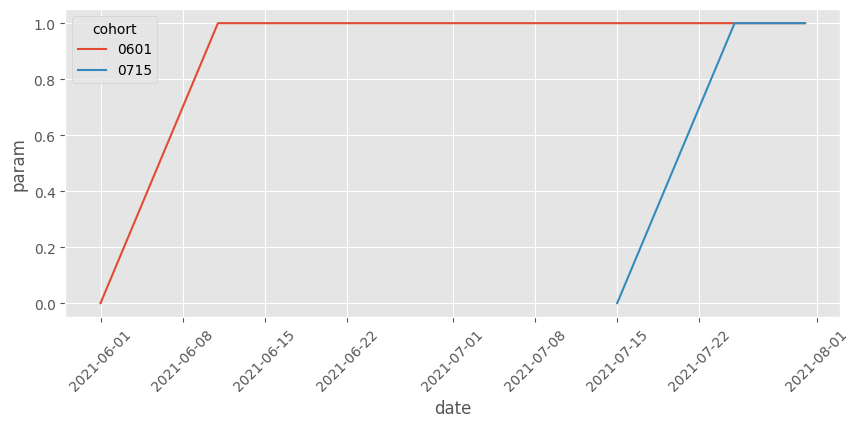

In [26]:
effects = (twfe_model.params[twfe_model.params.index.str.contains("treat")]
           .reset_index()
           .rename(columns={0:"param"})
           .assign(cohort=lambda d: d["index"].str.extract(r':cohort_(.*):'),
                   date_0601=lambda d: d["index"].str.extract(r':C\(date_0601\)\[(.*)\]'),
                   date_0715=lambda d: d["index"].str.extract(r':C\(date_0715\)\[(.*)\]'))
           .assign(date=lambda d: pd.to_datetime(d["date_0601"].combine_first(d["date_0715"]), errors="coerce")))

           
plt.figure(figsize=(10,4))
sns.lineplot(data=effects.dropna(subset=["date"]), x="date", y="param", hue="cohort")
plt.xticks(rotation=45);

두 `cohort`에 대한 효과의 형태가 같으므로 더 해볼 여지가 있습니다. 즉, 모델이 두 `cohort`에 대해 같은 효과가 있도록 제한합니다. 이를 위해서는 `event study design`과 마찬가지로 처치 후 날짜를 나타내는 `column`을 만들어야 합니다. 수식은 다음과 같습니다.

```
days_after_treat=1(date>cohort)*(date - cohort)
```

이 데이터는 `treat`와 상호작용합니다.

```
installs ~ treat:C(days_after_treat) + C(unit) + C(date)
```

여기서 멈추는 게 좋겠습니다. `cohort` 별로 이질성을 허용하지 않는 것은 편향을 가져올 수 있어 좋지 않은 생각입니다. 예를 들어 어느 정도 시간이 지나면 경쟁업체가 우리의 새로운 기능을 모방하여 효과가 감소할 수 있습니다.
 
마지막으로 `counterfactual`을 그려봅시다. 과학적인 검증 방법은 아니지만 이해에 도움을 줍니다.

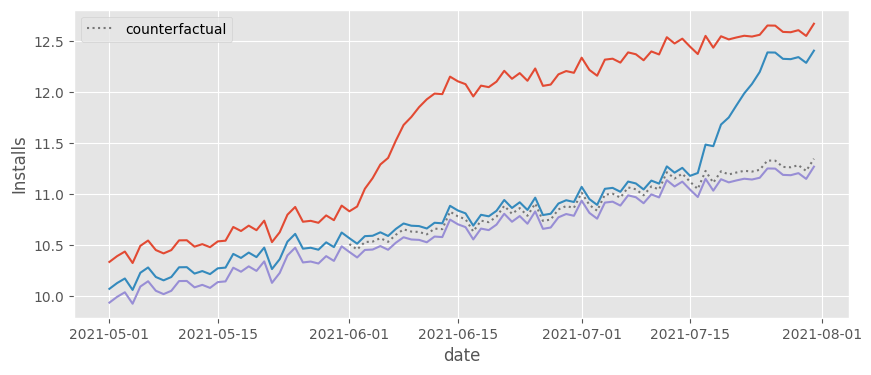

In [27]:
twfe_model_wrong = smf.ols("installs ~ treat + C(date) + C(unit)",
                           data=df_pred).fit()


df_pred = (df_pred
           .assign(**{"installs_hat_0_wrong": twfe_model_wrong.predict(df_pred.assign(**{"treat":0}))}))


plt.figure(figsize=(10,4))
sns.lineplot(
    data=(df_pred
          [(df_pred["cohort"].astype(str) > "2021-06-01") & (df_pred["date"].astype(str) >= "2021-06-01")]
          .groupby(["date"])["installs_hat_0"]
          .mean()
          .reset_index()),
    x="date",
    y = "installs_hat_0",
    ls="dotted",
    color="C3",
    label="counterfactual",
)

sns.lineplot(
    data=(df_pred
          .groupby(["cohort", "date"])["installs"]
          .mean()
          .reset_index()),
    x="date",
    y = "installs",
    hue="cohort",
    legend=None
)

plt.ylabel("Installs");

`counterfactual` $Y_0$ 예측값은 대조군과 매우 유사합니다. `TWFE` 모델은 $Y-\hat{Y_0}$를 잘 추정할 수 있습니다. `counterfactual`이 괜찮아 보이니 처치 효과도 좋을 것입니다.
 
나쁜 소식은 `DiD`와 `TWFE`의 독립성 가정과 관련된 더 큰 문제가 있다는 것입니다. `DiD`와 `TWFE`를 사용할 때 종종 독립성 가정에 관한 생각 없이 병렬 추세 가정을 사용합니다. 하지만 병렬 추세 가정은 생각보다 훨씬 제한적입니다. 많은 양을 공부했으므로 24장은 여기서 마칩니다.
 
## Key Concepts

`TWFE`의 `functional form` 문제를 이해하고 해결했습니다. 문제 원인인 시간 이질성을 해결하기 위해 모델에 더 많은 유연성을 부여했습니다. 이제 `TWFE`를 안전하게 사용해도 되는 걸까요?
 
![img](data/img/did-saga/twfeworking.png) 

`TWFE`(`DiD`)는 `independence assumption`(독립성 가정)도 만족해야 합니다. 더 큰 문제는 `DiD`의 독립성 가정인 병렬 추세입니다. 이는 잘 알려졌지만, 우리가 정확히 이해하고 있지는 않다고 생각합니다. 병렬 추세 가정은 생각보다 훨씬 더 많은 것을 요구합니다. 다음 장에서는 병렬 추게 가정에 대해 상세히 알아보겠습니다.
 
## Reference

It took a (very) long time to write this chapter. The recent econometric literature has been sprouting with new ideas and insights on the problems related to DiD and how to solve them. There are multiple angles we can see those problems, which in turn leads to multiple approaches we can leverage to solve them. Brace yourselves because the reference list here will be long (and probably not very well organized).
 
First, I took a lot from *Difference-in-Differences with Variation in Treatment Timing*, by Andrew Goodman-Bacon. His diagnosis of the problem is very neat and intuitive. Not to mention it comes with very nice pictures that gave me a clear understanding on how to understand what was happening with DiD. Some of the pictures in this chapter are almost a direct copy from those made by Goodman-Bacon.
 
The second major source of inspiration was *Difference-in-Differences with Multiple Time Periods*, by Pedro H. C. Sant'Anna and Brantly Callaway. Notice that the Callaway and Sant'Anna solution to this problem goes on a different route than the one we took. Still, their solution shines a lot of light on the DiD problem, making it easy to understand. The paper aside, Pedro has a very nice blog post showing the problems with TWFE. The Data Generating Process on that blog post heavily inspired the ones that I've used here. I’ve basically translated Pedro’s code from R to Python. Pedro was also very kind in helping me with some questions I had about the DiD assumptions. He has another very interesting article tackling the problem of adding covariates to the DiD models, which we didn’t cover here because the chapter was already too long. The name of the paper is *Doubly Robust Difference-in-Differences Estimators* and I strongly recommend you read it if you plan to add covariates to your model. 
 
Last, but definitely not least, the functional form fix we employed here was inspired on *Estimating dynamic treatment effects in event studies with heterogeneous treatment effects*, by Sun and Abraham and on *Two-Way Fixed Effects, the Two-Way Mundlak Regression, and Difference-in-Differences Estimators*, by Jeffrey Wooldridge. Although I've loved what Callaway and Sant'Anna did on their paper, their solution is a bit more complicated to implement. In contrast, Sun, Abraham and Wooldridge's solution involves nothing more than cleverly playing with interactions in a TWFE regression model, making it super easy to implement using nothing more than `statsmodels` and some formulas. 
 
Aside from the papers mentioned above, I've also relied on presentations given at the DiD Study Group, organized by Taylor Wright on Youtube. It is much easier to understand the articles mentioned above if you first watch the authors talk about them. I'm also very thankful for professor Yiqing Xu for tying all of this together in his amazing Causal Inference with Panel Data lecture series, also available on Youtube. 

Finally, keep in mind that I too am also learning, so, by all means, if you find something preposterous, open an issue and I'll address it to the best of my efforts.

## Contribute
 
Causal Inference for the Brave and True is an open-source material on causal inference, the statistics of science. It uses only free software, based in Python. Its goal is to be accessible monetarily and intellectually.
If you found this book valuable and you want to support it, please go to [Patreon](https://www.patreon.com/causal_inference_for_the_brave_and_true). If you are not ready to contribute financially, you can also help by fixing typos, suggesting edits or giving feedback on passages you didn't understand. Just go to the book's repository and [open an issue](https://github.com/matheusfacure/python-causality-handbook/issues). Finally, if you liked this content, please share it with others who might find it useful and give it a [star on GitHub](https://github.com/matheusfacure/python-causality-handbook/stargazers).